In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from sklearn.metrics import f1_score
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import BorderlineSMOTE
from sklearn import svm

from scipy import stats
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.pipeline import Pipeline

from collections import Counter
from nltk.data import load
from collections import deque

%matplotlib inline

In [2]:
combined = pd.read_csv('./wordBag.csv', sep = '\t')
data = combined.drop_duplicates(['lyrics'])

In [3]:
class popularityModel(object):
    """
    basically is returning the Mode
    """
    def __init__(self):
        self.mode = None
        return 
    
    def fit(self, X, y):
        """
        X: (number of examples k, number of features d.) nd array.
        y: (number of examples, ) nd array, or panda.series.
        """
        if X.shape[0] != y.shape[0]:
            print("error, dim not match")
            return
        self.mode = stats.mode(y.values, nan_policy='omit')[0][0]
        
    def predict(self, X):
        """
        X: (number of examples k_1, number of features d.) nd array.
        """
        if self.mode == None:
            print("Please fit the model first.")
            return
        
        return np.array([self.mode] * X.shape[0])
        
    

In [4]:
artist_10 = data.artist.value_counts()[:10]
data_10 = data[data.artist.isin(artist_10.index)]
train, test = train_test_split(data_10, test_size=0.2, random_state = 124, stratify = data_10.artist)
corpus = train['wordBag'].values.astype(str).tolist()
corpus_test = test['wordBag'].values.astype(str).tolist()

In [6]:
y = train.artist
y_true = test['artist']

# Feature engineering

## N-gram

### First try simply count with different range of n-grams.

In [7]:
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('model', LinearSVC())
])
parameters = {'count__max_features':[300,900,1500,3000,5000,10000], 'count__ngram_range':[(1,1),(1,2),(1,3),(1,4),(1,5)]}

clf_grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=True)
clf_grid.fit(corpus,y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.6min finished
/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'count__max_features': [300, 900, 1500, 3000, 5000, 10000], 'count__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [8]:
results = pd.melt(
pd.DataFrame(clf_grid.cv_results_),
id_vars=['param_count__max_features', 'param_count__ngram_range'],
value_vars=[
'mean_test_score'
],
value_name='f1_scores'
)

results = results.drop(['variable'], axis=1)

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/shirley/anaconda3/

In [9]:
def plot_results(results, title,xlable,ylable, huelable):
    f, ax = plt.subplots(figsize=(8, 5))
    sns.lineplot(ax=ax,
    x= xlable,
    y= ylable,
    hue = huelable,
    data=results)
    ax.set_xlabel(xlable)
    ax.set_ylabel('mean of prediction accuracy')
    ax.set_title(title)
    ax.legend(loc='lower right')

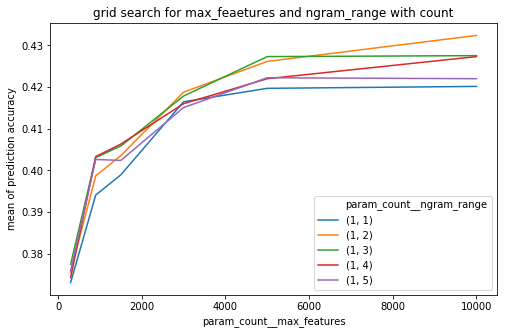

In [10]:
plot_results(results,'grid search for max_feaetures and ngram_range with count', 'param_count__max_features','f1_scores','param_count__ngram_range')

In [11]:
clf_grid.best_params_

{'count__max_features': 10000, 'count__ngram_range': (1, 2)}

In [13]:
clf_grid.best_score_

0.43239501615136133

For simply count we got best combination is max_features = 10000, ngram range (1,2), F1 score = 0.432

### Try tf-idf with different ngram range

In [35]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LinearSVC())
])
parameters = {'tfidf__max_features':[300,500,700,900,1200,1500,2000,3000], 'tfidf__ngram_range':[(1,1),(1,2),(1,3),(1,4),(1,5)]}

clf_grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=True)
clf_grid.fit(corpus,y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.8s
/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidf__max_features': [300, 500, 700, 900, 1200, 1500, 2000, 3000], 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [36]:
results = pd.melt(
pd.DataFrame(clf_grid.cv_results_),
id_vars=['param_tfidf__max_features', 'param_tfidf__ngram_range'],
value_vars=[
'mean_test_score'
],
value_name='f1_scores'
)

results = results.drop(['variable'], axis=1)

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/shirley/anaconda3/

In [38]:
def plot_results(results, title,xlable,ylable, huelable):
    f, ax = plt.subplots(figsize=(8, 5))
    sns.lineplot(ax=ax,
    x= xlable,
    y= ylable,
    hue = huelable,
    data=results)
    ax.set_xlabel(xlable)
    ax.set_ylabel('mean of prediction accuracy')
    ax.set_title(title)
    ax.legend(loc='lower right')

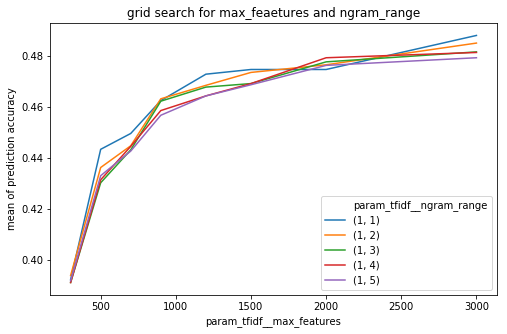

In [39]:

plot_results(results,'grid search for max_feaetures and ngram_range', 'param_tfidf__max_features','f1_scores','param_tfidf__ngram_range')

In [18]:
clf_grid.best_params_

{'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}

In [40]:
clf_grid.best_score_

0.488232579603138

Compared the two grid search we find that the tf-idf provides better results with the optimal parameters.

### Try SVD with simply count

try count with SVD see if it will perform better than before.

In [20]:
pipeline = Pipeline([
    ('count', CountVectorizer(max_features= 10000, ngram_range = (1,2))),
    ('svd',TruncatedSVD()),
    ('model', LinearSVC())
])
parameters = {'svd__n_components':[100,200,300,350,400,500,1000,3000,5000]}

clf_grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=True)
clf_grid.fit(corpus,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 12.0min finished
/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        str...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svd__n_components': [100, 200, 300, 350, 400, 500, 1000, 3000, 5000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [21]:
results = pd.melt(
pd.DataFrame(clf_grid.cv_results_),
id_vars=['param_svd__n_components'],
value_vars=[
'mean_test_score'
],
value_name='f1_scores'
)

results = results.drop(['variable'], axis=1)

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/shirley/anaconda3/

In [22]:
def plot_results(results, title,xlable,ylable):
    f, ax = plt.subplots(figsize=(8, 5))
    sns.lineplot(ax=ax,
    x= xlable,
    y= ylable,
    data=results)
    ax.set_xlabel(xlable)
    ax.set_ylabel('mean of prediction accuracy')
    ax.set_title(title)
    ax.legend(loc='lower right')

No handles with labels found to put in legend.


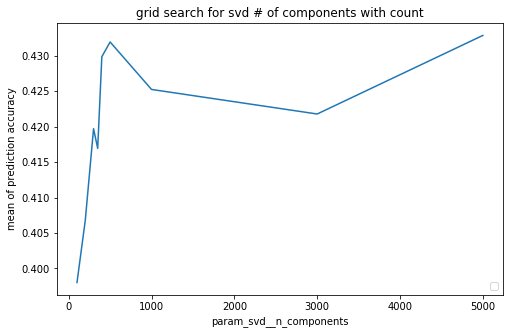

In [25]:
plot_results(results,'grid search for svd # of components with count', 'param_svd__n_components','f1_scores')

In [26]:
clf_grid.best_score_

0.43285648361790496

There is no obvious improvement using count followed by SVD.

try tf-idf with SVD see if it will perform better than before.

In [27]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features= 3000, ngram_range = (1,1))),
    ('svd',TruncatedSVD()),
    ('model', LinearSVC())
])
parameters = {'svd__n_components':[100,200,300,350,400,500,1000]}

clf_grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=True)
clf_grid.fit(corpus,y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   33.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svd__n_components': [100, 200, 300, 350, 400, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [29]:
results = pd.melt(
pd.DataFrame(clf_grid.cv_results_),
id_vars=['param_svd__n_components'],
value_vars=[
'mean_test_score'
],
value_name='f1_scores'
)

results = results.drop(['variable'], axis=1)

No handles with labels found to put in legend.


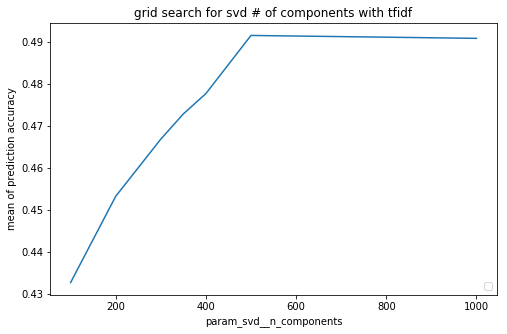

In [31]:
plot_results(results,'grid search for svd # of components with tfidf', 'param_svd__n_components','f1_scores')

In [32]:
clf_grid.best_score_

0.49146285186894323

In [34]:
clf_grid.best_params_

{'svd__n_components': 500}

The result is slightly better than model only with tf-idf.

Based on above grid search, we find the best performed model is the one using tf-idf with svd where tf-idf max_features = 3000, ngram_range = (1,1), svd number of components = 500.

## Vocabulary feature--type-token ratio

In [41]:
class uniqueWordRatioVec(object):
    '''
    convet bag of words(seperate by ' ') aka the "wordBag" column.
    to 
    [number of unique words/length of the lyrics] vec
    '''
    
    def __init__(self):
        '''
        self.dim: number of length of X, which is number lyrics.
        '''
        self.dim = 0
        self.vec = []
        return None
    
    def fitTransForm(self, X):
        """
        length self.dim, but contains [k_0, k_1, .. ,k_n] for k_i in range(0, 1)
        X is the "wordBag" column.
        """
        for wordbag in X:
            wordsList = wordbag.split(' ')
            self.vec.append(len(set(wordsList)) / len(wordsList))
        self.lengths = len(X)
        return np.array(self.vec)
            

uniqueWordvecX = uniqueWordRatioVec().fitTransForm(corpus)
uniqueWordvecX_test = uniqueWordRatioVec().fitTransForm(corpus_test)

In [43]:
vectorizer_t = TfidfVectorizer(max_features= 3000, ngram_range = (1,1))
svd = TruncatedSVD(n_components = 500)
clf = LinearSVC()                             

In [44]:
vectorizer_t.fit(corpus)
X_t = vectorizer_t.transform(corpus)
X_test_t = vectorizer_t.transform(corpus_test)
svd.fit(X_t)
X_d = svd.transform(X_t)
X_test_d = svd.transform(X_test_t)

In [125]:
clf.fit(X_d,y)
y_pred = clf.predict(X_test_d)


f1_score(y_true, y_pred, average = 'macro') 

0.49064646835626957

This is the best result with only tf-idf features.

In [49]:
X_new = np.c_[X_d,uniqueWordvecX]
X_test_new = np.c_[X_test_d, uniqueWordvecX_test]

In [52]:
clf.fit(X_new,y)
y_pred = clf.predict(X_test_new)


f1_score(y_true, y_pred, average = 'macro') 

0.4959295372260536

The F1 score increas to 0.496

## Lyrics style---- POS tag, length per line and repetition

In [53]:
class styleVector(object):
    """
    feature type: style:
    (1)   POS (map to super tag V N ADV)
    (2)   Length per line
    (3)   *Repetition:
    letter level: # of repeated letter >3
    word level: count 1 word and 2 words repetition as one feature
    """
    def __init__(self):
        self.dim = 0
        self.vec = []
        self.posTags = ['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 'JJ', 'VBZ', \
                        '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', '.', ',', '``', '$',\
                        'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', \
                        'NNS', 'SYM', 'CC', 'CD', 'POS']
        return
    
    def fitTransForm(self, X):
        """
        X is the "lyrics" column.
        """
        ct = 0
        for lyc in X:
            wordBaglyc = nltk.word_tokenize(lyc)
            
            
            posTag = self.generatePosTag(lyc, wordBaglyc)
            lengthPerLine = self.generateLenPerLine(lyc, wordBaglyc)
            repInfo = self.generateRepeatInfo(lyc, wordBaglyc)
            
            
            vec = posTag + [lengthPerLine] + repInfo
            
            ct += 1
            if ct % 100 == 0:
                print(ct, len(X))
                
            self.vec.append(vec)
        return np.array(self.vec)
            
    
    def generatePosTag(self, lyric, wordbaglyric):
        """
        lyric: an item of lyric.
        rtype: [count for each type], size is 45.
        wordbaglyric: str, word_tokenize version of lyric.
        """
        tagCount = Counter(x[1] for x in nltk.pos_tag(wordbaglyric))
        vec = [0] * 45
        for idx, tag in enumerate(self.posTags):
            if tag in tagCount.keys():
                vec[idx] = tagCount[tag]
        return vec
    
    def generateLenPerLine(self, lyric, wordbaglyric):
        """
        lyric: an item of lyric.
        rtype: double, (number of word)/(number of \n)
        wordbaglyric: str, word_tokenize version of lyric.
        """
        #wordCount = len(nltk.word_tokenize(lyric))
        wordCount = len(wordbaglyric)
        LineCount = Counter(lyric)['\n']
        if LineCount == 0:
            return wordCount
        return wordCount/LineCount
    
    def generateRepeatInfo(self, lyric, wordbaglyric):
        """
        lyric: an item of lyric.
        rtype: [count of reapeat letter > 3, count of repeat word, count of repeat 2-gram], size is 45.
        wordbaglyric: str, word_tokenize version of lyric.
        """
        ctRepeatChar = 0
        chQue = deque(maxlen = 3)
        for ch in lyric:
            chQue.append(ch.lower())
            if len(chQue) == 3:
                if chQue[0] == chQue[1] and chQue[1] == chQue[2]:
                    ctRepeatChar += 1
        
        words = wordbaglyric
        
        wordQueue = deque(maxlen = 2)
        twoGramQueue = deque(maxlen = 4)
        
        ctRepeatWord = 0
        ctRepeatTwoGram = 0
        
        for w in words:
            wordQueue.append(w.lower())
            twoGramQueue.append(w.lower())
            if len(wordQueue) == 2:
                if wordQueue[0] == wordQueue[1]:
                    ctRepeatWord += 1
            if len(twoGramQueue) == 4:
                if twoGramQueue[0] == twoGramQueue[2] and twoGramQueue[1] == twoGramQueue[3]:
                    ctRepeatTwoGram += 1
        
        return [ctRepeatChar, ctRepeatWord, ctRepeatTwoGram]
        

In [54]:
Xtest = test['lyrics'].values.astype(str).tolist()
Xtrain = train['lyrics'].values.astype(str).tolist()

In [61]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shirley/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [62]:
Xstyle = styleVector().fitTransForm(Xtrain)
X_teststyle = styleVector().fitTransForm(Xtest)

100 4334
200 4334
300 4334
400 4334
500 4334
600 4334
700 4334
800 4334
900 4334
1000 4334
1100 4334
1200 4334
1300 4334
1400 4334
1500 4334
1600 4334
1700 4334
1800 4334
1900 4334
2000 4334
2100 4334
2200 4334
2300 4334
2400 4334
2500 4334
2600 4334
2700 4334
2800 4334
2900 4334
3000 4334
3100 4334
3200 4334
3300 4334
3400 4334
3500 4334
3600 4334
3700 4334
3800 4334
3900 4334
4000 4334
4100 4334
4200 4334
4300 4334
100 1084
200 1084
300 1084
400 1084
500 1084
600 1084
700 1084
800 1084
900 1084
1000 1084


We add these three features into the model.

In [70]:
X_new_style = np.c_[X_d, Xstyle]
X_test_new_style = np.c_[X_test_d, X_teststyle]

In [75]:
Xstyle[:,:45].shape

(4334, 45)

In [71]:
clf.fit(X_new_style,y)
y_pred = clf.predict(X_test_new_style)


f1_score(y_true, y_pred, average = 'macro') 

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.3978117993212481

It seems that the features didn't help. We try to add one by one to see if any of them is effective for our model.

Add only POS tag to the model

In [77]:
X_new_style = np.c_[X_d, Xstyle[:,:45]]
X_test_new_style = np.c_[X_test_d, X_teststyle[:,:45]]

In [78]:
clf.fit(X_new_style,y)
y_pred = clf.predict(X_test_new_style)


f1_score(y_true, y_pred, average = 'macro') 

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.3757800825766353

The POS tags didn't work

In [79]:
X_new_style = np.c_[X_d, Xstyle[:,45]]
X_test_new_style = np.c_[X_test_d, X_teststyle[:,45]]

In [80]:
clf.fit(X_new_style,y)
y_pred = clf.predict(X_test_new_style)


f1_score(y_true, y_pred, average = 'macro') 

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5000221001009789

The length per line seems work

In [86]:
X_new_style = np.c_[X_new, Xstyle[:,46:]]
X_test_new_style = np.c_[X_test_new, X_teststyle[:,46:]]

In [87]:
clf.fit(X_new_style,y)
y_pred = clf.predict(X_test_new_style)


f1_score(y_true, y_pred, average = 'macro') 

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5026925638897466

The combination of the features we already have with length per line gives F1 socre equals to 0.503

try the repetition only

In [81]:
X_new_style = np.c_[X_d, Xstyle[:,46:]]
X_test_new_style = np.c_[X_test_d, X_teststyle[:,46:]]

In [82]:
clf.fit(X_new_style,y)
y_pred = clf.predict(X_test_new_style)


f1_score(y_true, y_pred, average = 'macro') 

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.4897907238588967

The repetition didn't work well

In [84]:
X_new_style = np.c_[X_d, Xstyle[:,45:]]
X_test_new_style = np.c_[X_test_d, X_teststyle[:,45:]]

In [85]:
clf.fit(X_new_style,y)
y_pred = clf.predict(X_test_new_style)


f1_score(y_true, y_pred, average = 'macro') 

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5024617670641515

The combination of the repetition and length per line gives the best results.

In [88]:
X_new_style = np.c_[X_new, Xstyle[:,45:]]
X_test_new_style = np.c_[X_test_new, X_teststyle[:,45:]]

In [89]:
clf.fit(X_new_style,y)
y_pred = clf.predict(X_test_new_style)


f1_score(y_true, y_pred, average = 'macro') 

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5076254310575671

The model that combines all the effective features gives the F1 socre 0.508

## Orientation----Past tense ratio, self-reference ratio, the ratio of first-person singular pronouns to second person

In [104]:
class orientatedVec(object):
    
    def __init__(self):
        """
        initial vector.
        """
        self.vec = []
        self.dim = None
        return None
    
    def fitTransform(self, X):
        """
        input: X is the 'wordbag' column. (k, ) dimension
        output: (k, 3) vec. 
        """
        for lyric in X:
            lyricwBag = lyric.split(' ')
            pastR = self.generatePastVerbRatio(lyricwBag)
            selfRefVec = self.generateSelfRefToOthersandToSecond(lyricwBag)
            self.vec.append([pastR] + selfRefVec)
        self.dim = len(X)
        self.vec = np.array(self.vec)
        return self.vec
        
    def generatePastVerbRatio(self, lyricWordBag):
        """
        Past tense ratio: the fraction of past tense verb forms to all verb forms as a feature
        input: list of str, list of words in lyric.
        rtype: float, ratio, from 0 to 1.
        """
        pTags = nltk.pos_tag(lyricWordBag)
        verbCount = Counter(x[1][0] for x in pTags)['V']
        pastCount = Counter(x[1] for x in pTags)['VBN']
        if verbCount == 0:
            return 0
        return pastCount/verbCount
    def generateSelfRefToOthersandToSecond(self, lyricWordBag):
        """
        Self-reference ratio: # of the first person singular and plural/ 2 and 3 person
        input: list of str, word bag of lyric
        rtype: [float, float] ratio, range vaires. [one / other, one / second]
        """
        firstPersonSingular = set(['i', 'me', 'my'])
        secondPersonSingular = set(['you', 'your'])
        thirdPersonSingular = set(['it', 'its', 'he', 'his', 'him', 'she', 'her'])
        
        firstPersonCount = 0
        secondPersonCount = 0
        thirdPersonCount = 0
        
        for word in lyricWordBag:
            if word in firstPersonSingular:
                firstPersonCount += 1
            if word in secondPersonSingular:
                secondPersonCount += 1
            if word in thirdPersonSingular:
                thirdPersonCount += 1
        
        if secondPersonCount + thirdPersonCount == 0:
            return [0, 0]
            #if the sum is zero, all of the counts are zeros.
        if secondPersonCount == 0 and thirdPersonCount != 0:
            return [firstPersonCount/thirdPersonCount, 0]
        if thirdPersonCount == 0 and secondPersonCount != 0:
            return [0, firstPersonCount/secondPersonCount]
        return [firstPersonCount/(secondPersonCount + thirdPersonCount), firstPersonCount/(secondPersonCount)]

In [105]:
X_ori = orientatedVec().fitTransform(corpus)
X_test_ori = orientatedVec().fitTransform(corpus_test)

In [108]:
X_new_ori = np.c_[X_d, X_ori]
X_test_new_ori = np.c_[X_test_d, X_test_ori]

In [109]:
clf.fit(X_new_ori,y)
y_pred = clf.predict(X_test_new_ori)


f1_score(y_true, y_pred, average = 'macro') 

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.4928701784554046

The F1 score with orientation slightly increased.

In [112]:
X_new_ori = np.c_[X_new_style, X_ori]
X_test_new_ori = np.c_[X_test_new_style, X_test_ori]

In [113]:
clf.fit(X_new_ori,y)
y_pred = clf.predict(X_test_new_ori)


f1_score(y_true, y_pred, average = 'macro') 

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.4965290476331005

Add the orientation features, we got 0.497 F1 score which is lower than before. Let us see if any of the features belong to this category could help improve the model.

In [115]:
X_new_ori = np.c_[X_d, X_ori[:,0]]
X_test_new_ori = np.c_[X_test_d, X_test_ori[:,0]]

In [116]:
clf.fit(X_new_ori,y)
y_pred = clf.predict(X_test_new_ori)


f1_score(y_true, y_pred, average = 'macro') 

0.4881715846388798

In [117]:
X_new_ori = np.c_[X_d, X_ori[:,1]]
X_test_new_ori = np.c_[X_test_d, X_test_ori[:,1]]

In [118]:
clf.fit(X_new_ori,y)
y_pred = clf.predict(X_test_new_ori)


f1_score(y_true, y_pred, average = 'macro') 

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.4902397241657116

In [119]:
X_new_ori = np.c_[X_d, X_ori[:,2]]
X_test_new_ori = np.c_[X_test_d, X_test_ori[:,2]]

In [120]:
clf.fit(X_new_ori,y)
y_pred = clf.predict(X_test_new_ori)


f1_score(y_true, y_pred, average = 'macro') 

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.4921097718117039

In [121]:
X_new_ori = np.c_[X_d, X_ori[:,:2]]
X_test_new_ori = np.c_[X_test_d, X_test_ori[:,:2]]

In [122]:
clf.fit(X_new_ori,y)
y_pred = clf.predict(X_test_new_ori)


f1_score(y_true, y_pred, average = 'macro') 

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.48888006527935535

In [123]:
X_new_ori = np.c_[X_d, X_ori[:,1:]]
X_test_new_ori = np.c_[X_test_d, X_test_ori[:,1:]]

In [124]:
clf.fit(X_new_ori,y)
y_pred = clf.predict(X_test_new_ori)


f1_score(y_true, y_pred, average = 'macro')

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.49479309160892837

In [126]:
X_new_ori = np.c_[X_d, X_ori[:,[0,2]]]
X_test_new_ori = np.c_[X_test_d, X_test_ori[:,[0,2]]]

In [127]:
clf.fit(X_new_ori,y)
y_pred = clf.predict(X_test_new_ori)


f1_score(y_true, y_pred, average = 'macro')

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.4905577827800668

Based on above results, the past tense ratio doesn't work. Thus, we only choose the rest of orientation features to be added in our model.

In [128]:
X_new_ori = np.c_[X_new_style, X_ori[:,1:]]
X_test_new_ori = np.c_[X_test_new_style, X_test_ori[:,1:]]

In [129]:
clf.fit(X_new_ori,y)
y_pred = clf.predict(X_test_new_ori)


f1_score(y_true, y_pred, average = 'macro')

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5091398583306856

After add these features, we got 0.509 F1 score.

### Another orientation feature--negative/positive third persion ratio

In [132]:
class negPosThirdPerson(object):
    """
    build a feature with:
    [
    [# of positive third person purals] / [# of positive third person purals] + [# of negative third person purals],
    [# of negative third person purals] / [# of positive third person purals] + [# of negative third person purals]
    ],
    sum of the vector should be one, if [# of positive third person purals] + [# of negative third person purals] == 0,
    will set the vector to [0.5, 0.5]
    """
    
    def __init__(self):
        """
        self.dim : number of lyrics, (k, 1) the k.
        self.vec : the vec [(0.5, 0.5), (0.2, 0.8) ,..., (...)]
        """
        self.dim = None
        self.vec = []
    def transform(self, bagsOfWords):
        """
        input: bagsOfWords column
        output: np.array of feature vector.
        bagsOfWords should be the column of word bags.
        """
        postivePrunals = set(['he', 'him', 'his'])
        negtivePrunals = set(['she', 'her'])
        
        
        for bag in bagsOfWords:
            """
            vec: [(positive ratio, negetive ratio)]
            """
            vec = []
            
            posCount = 0
            negCount = 0
            
            wordList = bag.split(' ')
            for word in wordList:
                
                if word in postivePrunals:
                    posCount += 1
                if word in negtivePrunals:
                    negCount += 1
#             if posCount != 0 and negCount != 0:
#                 print(negCount, posCount)
            if posCount + negCount == 0:
                self.vec.append([0.5, 0.5])
            else:
                self.vec.append([posCount/(posCount + negCount), negCount/(posCount + negCount)])
        self.vec = np.array(self.vec)
        return self.vec

In [136]:
negPosThirdPersonX = negPosThirdPerson().transform(corpus)
negPosThirdPersonX_test = negPosThirdPerson().transform(corpus_test)

In [137]:
X_new_np = np.c_[X_d, negPosThirdPersonX]
X_test_new_np = np.c_[X_test_d, negPosThirdPersonX_test]

In [138]:
clf.fit(X_new_np,y)
y_pred = clf.predict(X_test_new_np)


f1_score(y_true, y_pred, average = 'macro')

0.4929142324416616

A little bit increase.

In [139]:
X_new_np = np.c_[X_new_ori, negPosThirdPersonX]
X_test_new_np = np.c_[X_test_new_ori, negPosThirdPersonX_test]

In [140]:
clf.fit(X_new_np,y)
y_pred = clf.predict(X_test_new_np)


f1_score(y_true, y_pred, average = 'macro')

/Users/shirley/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5131237095649117

Finally we got 0.513 F1 score after feature enigneering.